In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

180


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,workspace,None,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,direct/helpful-output-format-few.txt,cq.txt,auto/direct.json,...,12,102,5.725490,2.466235,3,4.00,5.0,7.00,13,direct
1,e07405908fdcf872a458adabbdf8502d8399de3a,total-rale,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/format-relevant-few.txt,cq.txt,auto/cte.json,...,78,81,48.839506,15.702274,23,37.00,45.0,57.00,99,cte
2,53d48ddb2cce1969e0b95899a0fe2902761fba71,naggy-seed,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/format-relevant-few.txt,cq.txt,auto/cte.json,...,78,74,47.783784,16.178178,22,36.25,43.5,56.00,107,cte
3,af76aff38a17c998abdb3b5eaa55e65ae987bb53,boric-sook,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/format-relevant-few.txt,cq.txt,auto/cte.json,...,74,78,48.025641,15.152878,20,38.25,45.0,58.75,84,cte
4,9e8f1b22ee530dddcd72a2aaf0077635bc480266,jaggy-ices,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/format-relevant-few.txt,cq.txt,auto/cte.json,...,81,71,50.014085,17.013014,14,40.00,47.0,58.50,100,cte


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df.head()

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/format-thought.txt,cq.txt,auto/ccot.json,0,1,0.570000,0.671448,0.64,0.744558,...,91,104,57.846154,19.600262,23,45.0,54.0,66.75,100,ccot
1,0.1,ccot/format-thought.txt,cq.txt,auto/ccot.json,0,2,0.576667,0.687011,0.62,0.741024,...,88,97,54.082474,17.526569,23,42.0,51.0,61.00,107,ccot
2,0.1,ccot/format-thought.txt,cq.txt,auto/ccot.json,0,3,0.586667,0.686113,0.66,0.767331,...,97,101,55.702970,17.734455,23,45.0,54.0,65.00,100,ccot
3,0.7,ccot/format-thought.txt,cq.txt,auto/ccot.json,0,1,0.563333,0.671236,0.61,0.737733,...,97,103,54.310680,19.319821,20,39.5,51.0,67.50,99,ccot
4,0.7,ccot/format-thought.txt,cq.txt,auto/ccot.json,0,2,0.563333,0.658519,0.62,0.732844,...,84,109,57.596330,20.718179,22,43.0,54.0,70.00,100,ccot


In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) != 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,params.run


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df['params.qa.system_prompt'].unique()

array(['ccot/format-thought', 'cot/format-thought',
       'cte/excellent-format-few', 'cte/format-relevant-few',
       'direct/helpful-output-format-few'], dtype=object)

In [8]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
0,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,0.577778,0.681524,0.640000,0.750971,...,54.333333,92.000000,100.666667,55.877199,18.287095,23.000000,44.000000,53.000000,64.250000,102.333333
1,ccot,ccot/format-thought,cq,auto/ccot,0,0.7,0.562222,0.668001,0.610000,0.728140,...,55.000000,93.333333,105.000000,55.373534,20.123936,20.333333,40.000000,52.666667,67.333333,99.666667
2,ccot,ccot/format-thought,cq,auto/ccot,1,0.1,0.626667,0.724480,0.636667,0.750416,...,55.916667,92.333333,87.333333,54.078995,16.766783,20.000000,42.000000,53.000000,64.333333,99.333333
3,ccot,ccot/format-thought,cq,auto/ccot,1,0.7,0.607778,0.707637,0.633333,0.743447,...,56.500000,89.666667,92.333333,56.298150,18.563093,20.666667,42.166667,54.000000,68.833333,103.333333
4,ccot,ccot/format-thought,cq,auto/ccot,2,0.1,0.608889,0.708503,0.623333,0.738413,...,53.000000,93.666667,92.000000,55.971014,18.340615,19.000000,43.333333,51.500000,67.750000,100.000000


In [9]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
32,cte,cte/excellent-format-few,cq,auto/cte,6,0.1,0.635556,0.760395,0.656667,0.795356,...,51.666667,87.000000,74.666667,47.682432,17.121792,13.000000,36.083333,44.500000,56.750000,100.000000
11,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,0.633333,0.741454,0.640000,0.763719,...,50.333333,89.333333,80.666667,52.391826,16.318943,17.333333,41.000000,51.166667,63.583333,93.000000
56,direct,direct/helpful-output-format-few,cq,auto/direct,6,0.1,0.622222,0.733165,0.623333,0.759019,...,6.000000,15.666667,85.000000,6.200385,5.468503,3.000000,4.000000,5.000000,6.000000,36.333333
18,cot,cot/format-thought,cq,auto/cot,3,0.1,0.608889,0.702671,0.666667,0.769139,...,72.333333,100.666667,93.666667,73.122597,19.199220,28.000000,57.416667,71.166667,94.500000,104.666667


## Visualizations

In [10]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["n_shot"].map(str)
    )

    return dataf


In [11]:
def plot_variance(dataf, x='temperature', y='f1', hue='prompt', technique=None, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    if technique:
        dataf = dataf[dataf['technique'] == technique]
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, hue=hue, data=dataf, linewidth=2.5, legend=legend)
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [12]:
prepared_df = prepare_data(df)
zero_shot_mask = prepared_df["n_shot"] == 0
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
0,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,1,0.570000,0.671448,ccot/format-thought | cq | 0
1,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,2,0.576667,0.687011,ccot/format-thought | cq | 0
2,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,3,0.586667,0.686113,ccot/format-thought | cq | 0
3,ccot,ccot/format-thought,cq,auto/ccot,0,0.7,1,0.563333,0.671236,ccot/format-thought | cq | 0
4,ccot,ccot/format-thought,cq,auto/ccot,0,0.7,2,0.563333,0.658519,ccot/format-thought | cq | 0
...,...,...,...,...,...,...,...,...,...,...
175,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.1,2,0.606667,0.716138,direct/helpful-output-format-few | cq | 9
176,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.1,3,0.616667,0.722911,direct/helpful-output-format-few | cq | 9
177,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.7,1,0.616667,0.729136,direct/helpful-output-format-few | cq | 9
178,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.7,2,0.613333,0.721349,direct/helpful-output-format-few | cq | 9


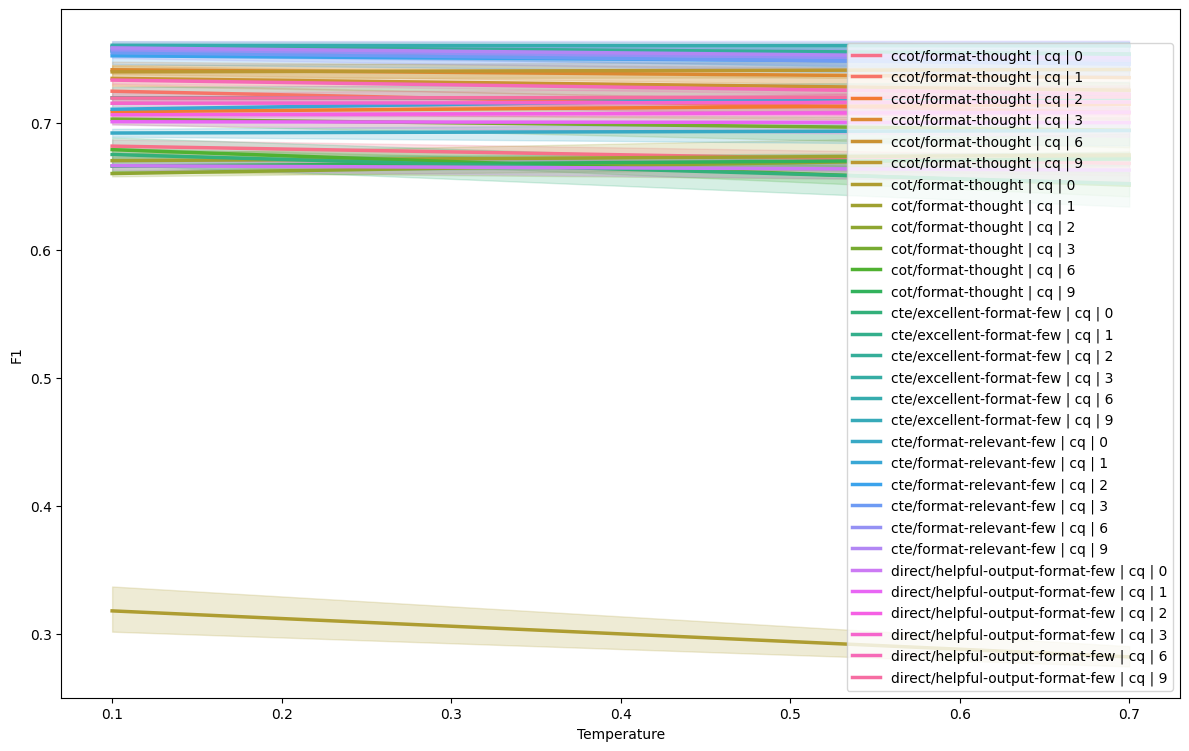

In [13]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [14]:
def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

def one_way_anova_by_nshot(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    
    # Perform One-Way ANOVA at each n-shot
    nshot_values = dataf["n_shot"].unique()
    for nshot in nshot_values:
        _dataf = dataf[dataf["n_shot"] == nshot]
        grouped = _dataf.groupby("technique")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping n-shot {nshot}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for n-shot {nshot:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [15]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # One-Way ANOVA by n-shot
    one_way_anova_by_nshot(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

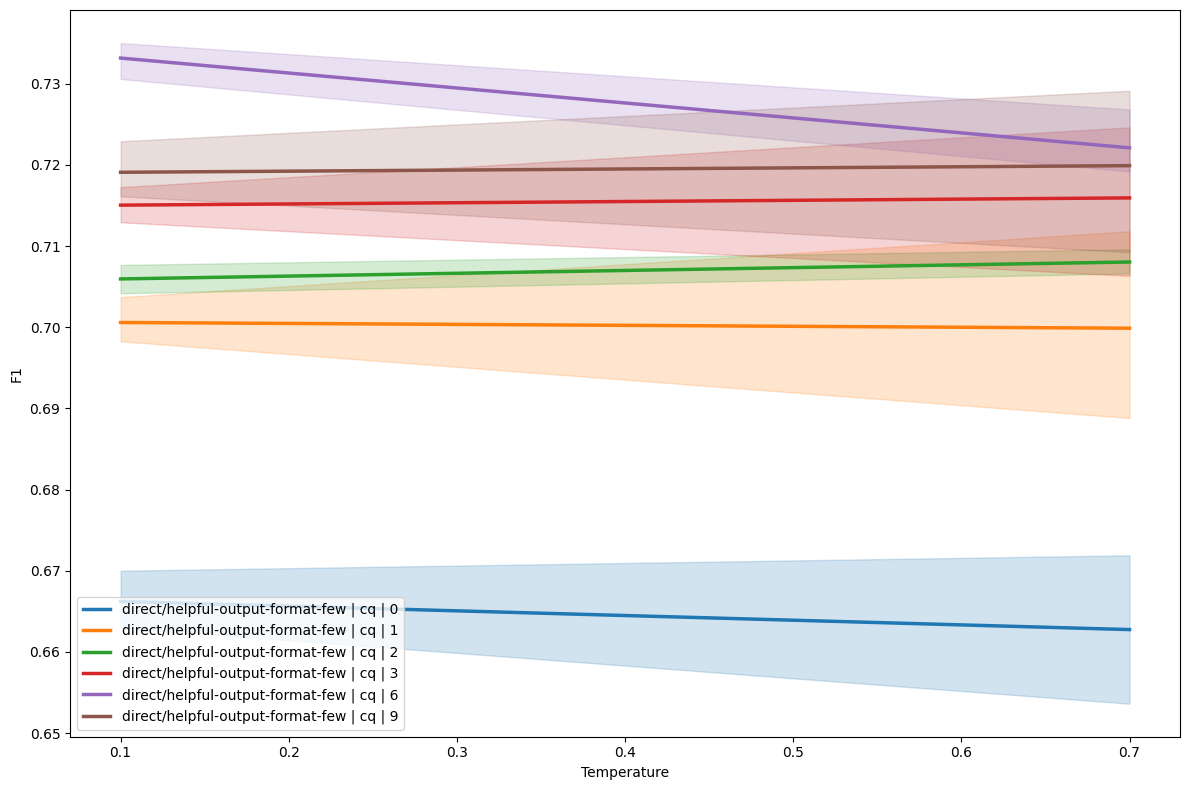

In [16]:
plot_variance(prepared_df, technique='direct', legend='brief')

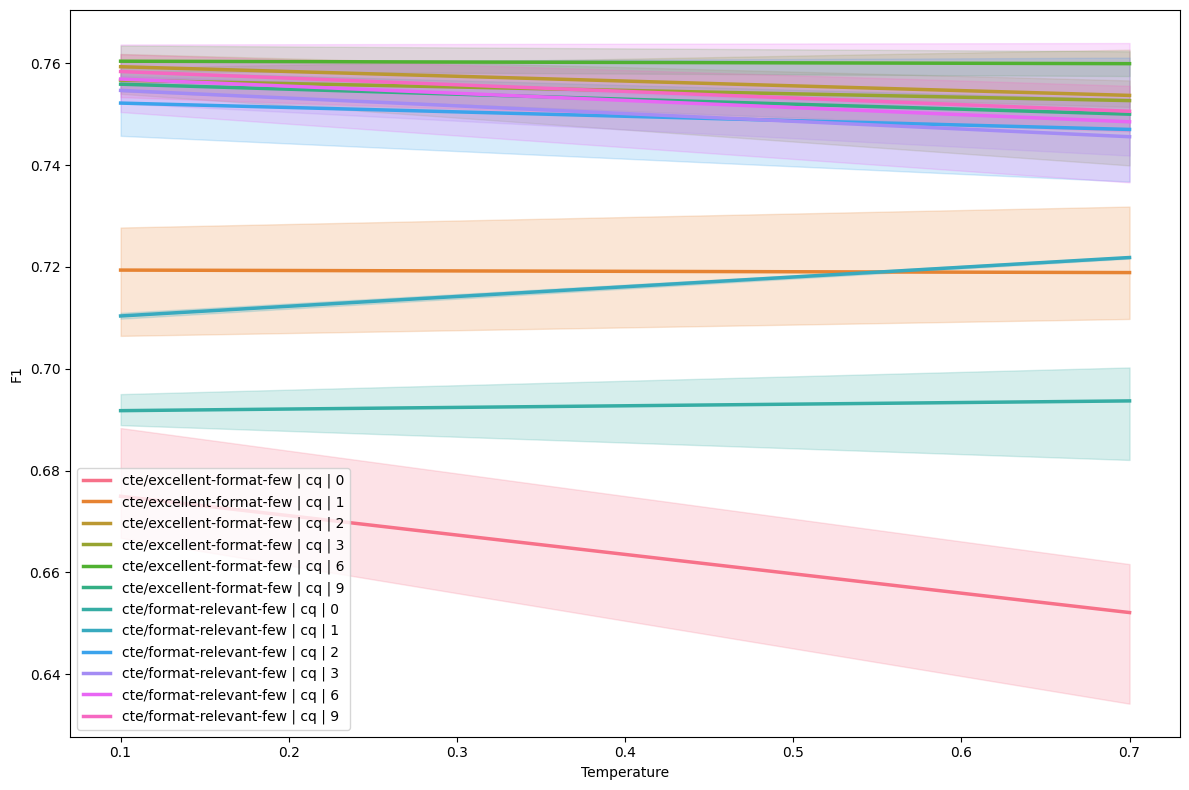

In [17]:
plot_variance(prepared_df, technique='cte', legend='brief')

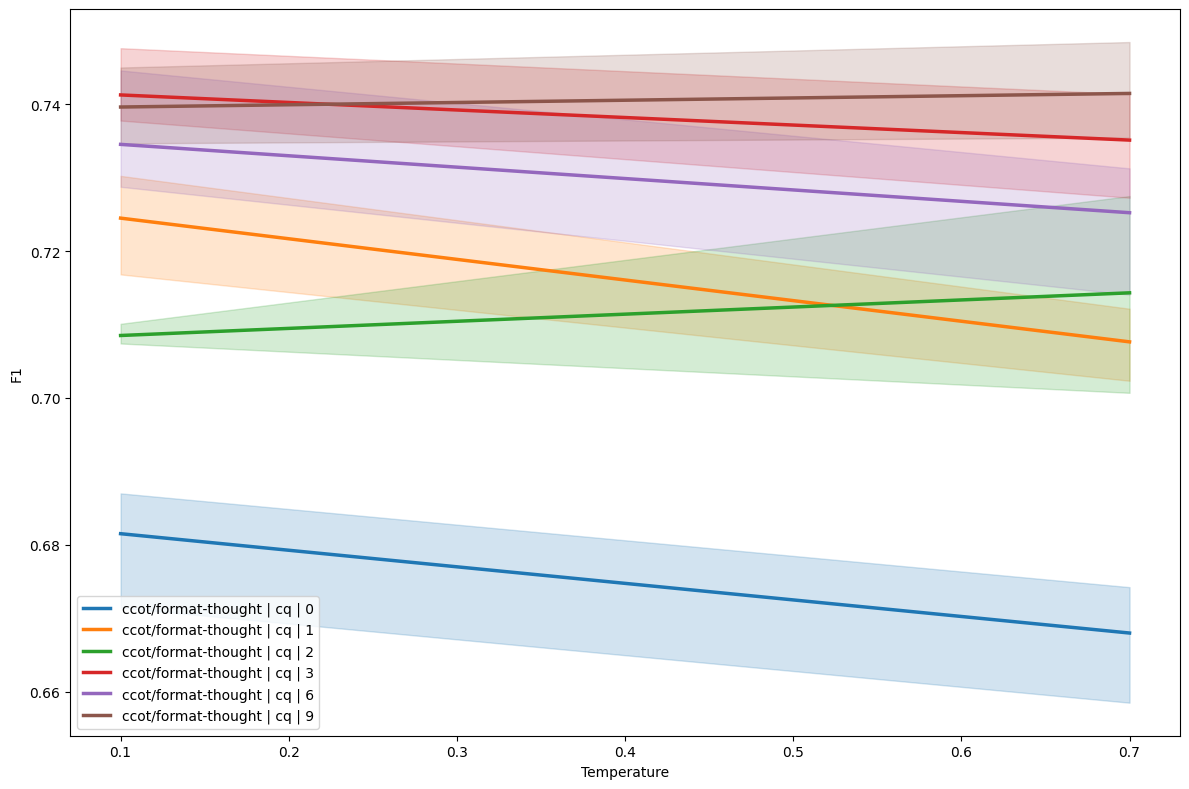

In [18]:
plot_variance(prepared_df, technique='ccot', legend='brief')

In [19]:
report(prepared_df[prepared_df['temperature'] == 0.1])

Prompt values
	 ccot/format-thought | cq | 0
	 ccot/format-thought | cq | 1
	 ccot/format-thought | cq | 2
	 ccot/format-thought | cq | 3
	 ccot/format-thought | cq | 6
	 ccot/format-thought | cq | 9
	 cot/format-thought | cq | 0
	 cot/format-thought | cq | 1
	 cot/format-thought | cq | 2
	 cot/format-thought | cq | 3
	 cot/format-thought | cq | 6
	 cot/format-thought | cq | 9
	 cte/excellent-format-few | cq | 0
	 cte/excellent-format-few | cq | 1
	 cte/excellent-format-few | cq | 2
	 cte/excellent-format-few | cq | 3
	 cte/excellent-format-few | cq | 6
	 cte/excellent-format-few | cq | 9
	 cte/format-relevant-few | cq | 0
	 cte/format-relevant-few | cq | 1
	 cte/format-relevant-few | cq | 2
	 cte/format-relevant-few | cq | 3
	 cte/format-relevant-few | cq | 6
	 cte/format-relevant-few | cq | 9
	 direct/helpful-output-format-few | cq | 0
	 direct/helpful-output-format-few | cq | 1
	 direct/helpful-output-format-few | cq | 2
	 direct/helpful-output-format-few | cq | 3
	 direct/helpful-o

### All techniques

In [20]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_df = _data.loc[prompt_mask]
best_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
30,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,1,0.653333,0.744984,ccot/format-thought | cq | 9
31,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,2,0.646667,0.739173,ccot/format-thought | cq | 9
32,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,3,0.636667,0.734658,ccot/format-thought | cq | 9
33,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,1,0.630000,0.735438,ccot/format-thought | cq | 9
34,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,2,0.626667,0.740475,ccot/format-thought | cq | 9
35,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,3,0.643333,0.748451,ccot/format-thought | cq | 9
54,cot,cot/format-thought,cq,auto/cot,3,0.1,1,0.610000,0.703229,cot/format-thought | cq | 3
55,cot,cot/format-thought,cq,auto/cot,3,0.1,2,0.603333,0.698697,cot/format-thought | cq | 3
56,cot,cot/format-thought,cq,auto/cot,3,0.1,3,0.613333,0.706086,cot/format-thought | cq | 3
57,cot,cot/format-thought,cq,auto/cot,3,0.7,1,0.616667,0.704035,cot/format-thought | cq | 3


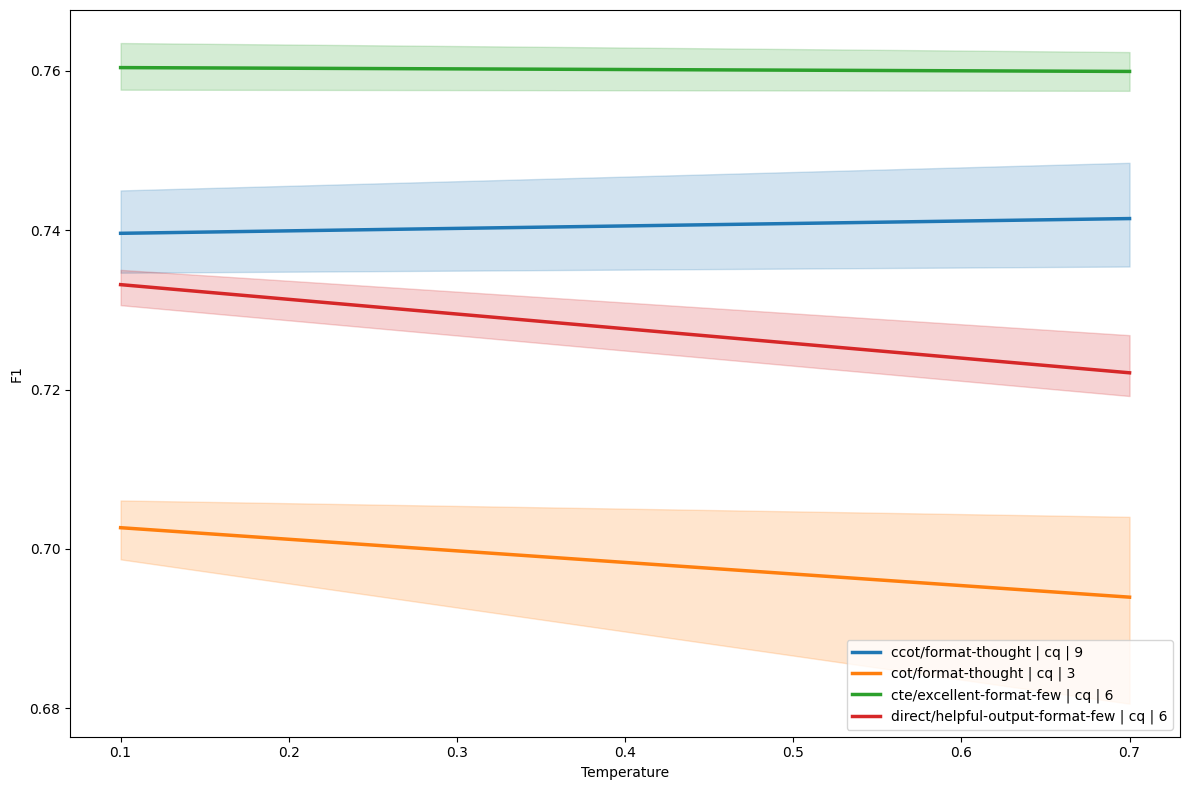

In [21]:
plot_variance(best_prepared_df, figsize=(12, 8), legend_loc='lower right')

In [22]:
report(best_prepared_df)

Prompt values
	 ccot/format-thought | cq | 9
	 cot/format-thought | cq | 3
	 cte/excellent-format-few | cq | 6
	 direct/helpful-output-format-few | cq | 6


Temperature values:  0.1, 0.7


One-Way ANOVA for Temperature 0.1:
F-statistic: 125.2632, p-value: 4.6072e-07
One-Way ANOVA for Temperature 0.7:
F-statistic: 45.1210, p-value: 2.3323e-05


Skipping n-shot 9: Not enough groups to perform ANOVA
Skipping n-shot 3: Not enough groups to perform ANOVA
One-Way ANOVA for n-shot 6.0:
F-statistic: 123.1228, p-value: 6.0799e-07


                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                
              group1                                group2                  meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------
     ccot/format-thought | cq | 9               cot/format-thought | cq | 3  -0.0422    0.0 -0.0566 -0.0278   True
     ccot/f

## Inspect

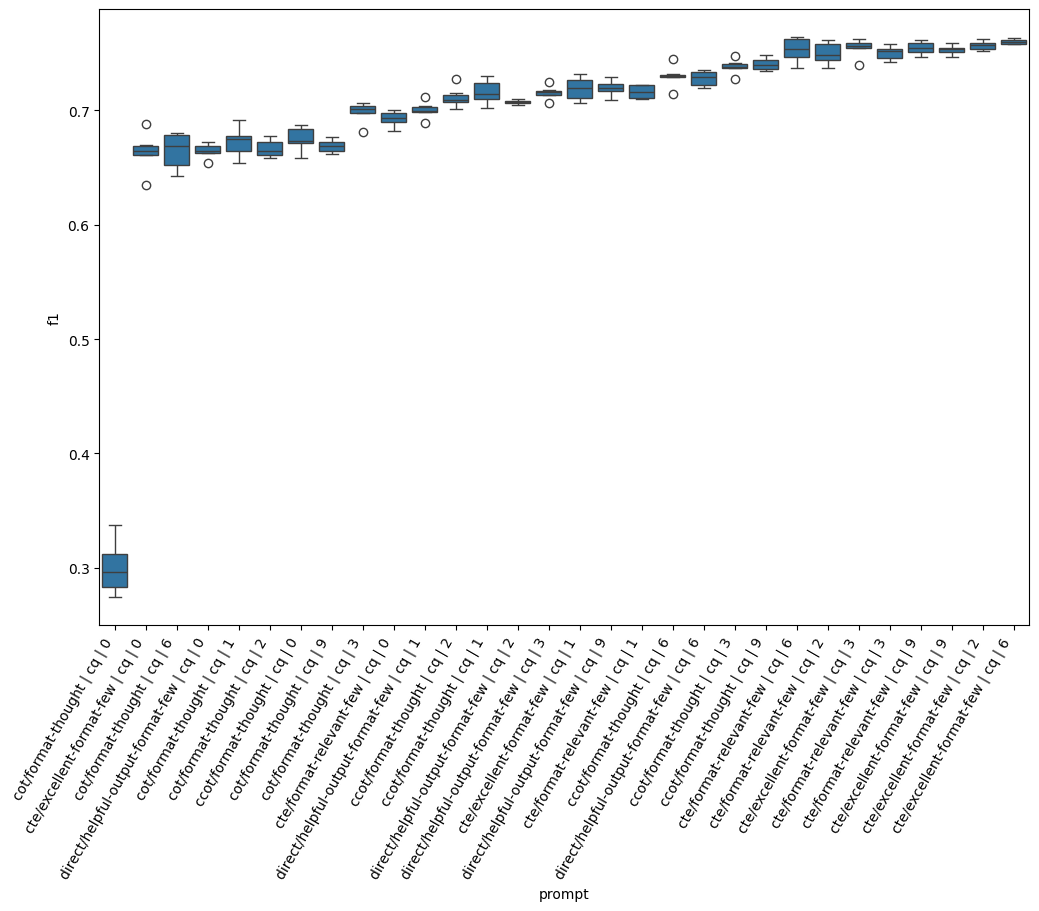

In [23]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.sort_values(by="f1"),
)
plt.xticks(rotation=60, ha="right");

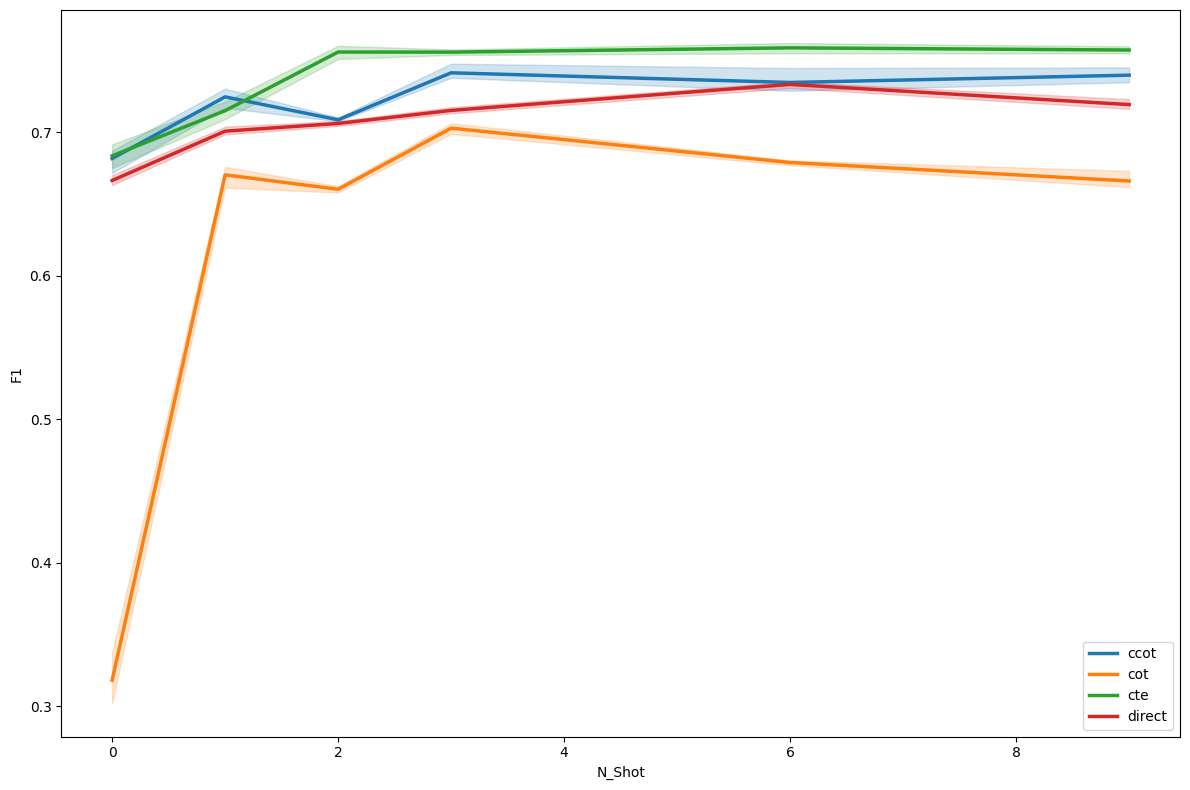

In [24]:
plot_variance(prepared_df[prepared_df['temperature'] == 0.1], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [25]:
prepared_df['temperature'].unique()

array([0.1, 0.7])

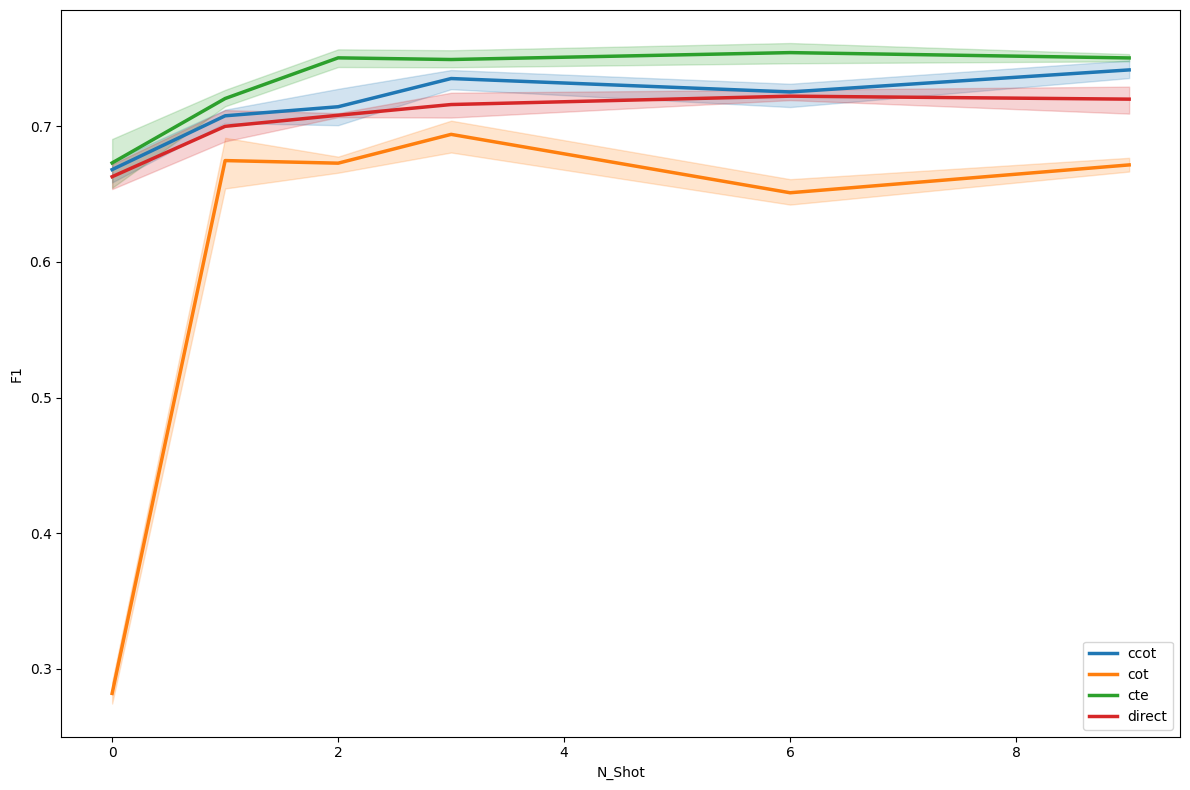

In [26]:
plot_variance(prepared_df[prepared_df['temperature'] > 0.6], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [27]:
df

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/format-thought,cq,auto/ccot,0,1,0.570000,0.671448,0.64,0.744558,...,91,104,57.846154,19.600262,23,45.0,54.0,66.75,100,ccot
1,0.1,ccot/format-thought,cq,auto/ccot,0,2,0.576667,0.687011,0.62,0.741024,...,88,97,54.082474,17.526569,23,42.0,51.0,61.00,107,ccot
2,0.1,ccot/format-thought,cq,auto/ccot,0,3,0.586667,0.686113,0.66,0.767331,...,97,101,55.702970,17.734455,23,45.0,54.0,65.00,100,ccot
3,0.7,ccot/format-thought,cq,auto/ccot,0,1,0.563333,0.671236,0.61,0.737733,...,97,103,54.310680,19.319821,20,39.5,51.0,67.50,99,ccot
4,0.7,ccot/format-thought,cq,auto/ccot,0,2,0.563333,0.658519,0.62,0.732844,...,84,109,57.596330,20.718179,22,43.0,54.0,70.00,100,ccot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.1,direct/helpful-output-format-few,cq,auto/direct,9,2,0.606667,0.716138,0.59,0.724157,...,14,89,8.820225,11.277050,3,4.0,5.0,8.00,70,direct
176,0.1,direct/helpful-output-format-few,cq,auto/direct,9,3,0.616667,0.722911,0.60,0.727981,...,14,87,8.827586,12.407056,3,4.0,5.0,7.50,79,direct
177,0.7,direct/helpful-output-format-few,cq,auto/direct,9,1,0.616667,0.729136,0.59,0.726704,...,17,84,9.166667,12.437636,3,4.0,5.0,7.25,61,direct
178,0.7,direct/helpful-output-format-few,cq,auto/direct,9,2,0.613333,0.721349,0.59,0.728280,...,14,86,9.860465,13.180344,3,4.0,5.0,8.00,75,direct
